In [1]:
import mymodel
import tensorflow as tf
from glob import glob
import os
import cv2
from PIL import Image
from keras.utils import normalize
import numpy as np



2022-01-21 18:43:28.805745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-21 18:43:31.403725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-21 18:43:31.413434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-21 18:43:31.679745: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-21 18:43:31.680107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.695GHz coreCount: 34 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-21 18:43:31.680140: I tensorflow/stream_executor/

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

Using TensorFlow backend.


In [2]:
img_dataset = []
msk_dataset = []

f_img = sorted(glob('dataset/train/*'))
for f in f_img:
    image = cv2.imread(f)
    image = Image.fromarray(image)
    # image = image.resize((SIZE, SIZE))
    img_dataset.append(np.array(image))

f_msk = sorted(glob('dataset/validation/*'))
for f in f_msk:
    image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    image = Image.fromarray(image)
    # image = image.resize((SIZE, SIZE))
    msk_dataset.append(np.array(image))

# img_dataset = (img_dataset - v_min)/(v_max - v_min)
# print(img_dataset.shape)
# #Normalize images
img_dataset = normalize(np.array(img_dataset), axis=1)
# img_dataset = np.array(img_dataset)
# #D not normalize masks, just rescale to 0 to 1.
msk_dataset = np.expand_dims(np.array(msk_dataset) /255., -1)

In [3]:
print(img_dataset.shape, msk_dataset.shape)

(249, 256, 256, 3) (249, 256, 256, 1)


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(img_dataset, msk_dataset, test_size= 0.08, random_state=0)
# y_train = to_categorical(y_train, 3)

In [5]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(229, 256, 256, 3) (229, 256, 256, 1) (20, 256, 256, 3) (20, 256, 256, 1)


## DATA SANITY CHECK

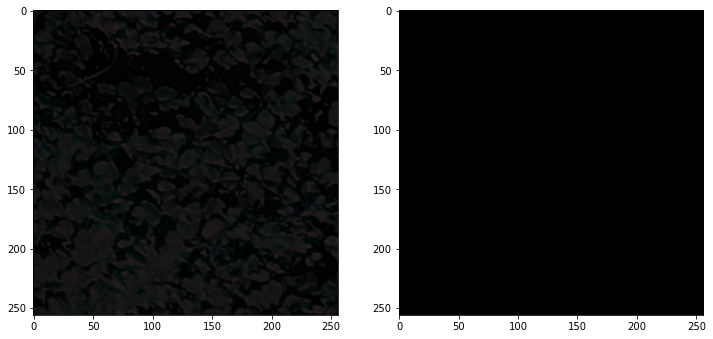

In [6]:
import random
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
X_train_quick_test, X_test_quick_test, y_train_quick_test, y_test_quick_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 0)
image_number = random.randint(0, len(X_train_quick_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train_quick_test[image_number], (256, 256,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train_quick_test[image_number], (256, 256,1)), cmap='gray')
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
    
# model = Sequential()
# model.add(Conv2D(filters =32, kernel_size = (32,32), padding = "same", activation = "relu", input_shape = INP))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (3,3)))
# model.add(Conv2D(filters = 32, kernel_size = (32,32), padding = "same", activation = "relu", input_shape = (100,100)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(filters = 32, kernel_size = (32,32), padding = "same", activation = "relu", input_shape = (50, 50)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(filters = 32, kernel_size = (32,32), padding = "same", activation = "relu", input_shape = (25, 25)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Flatten())
# model.add(Dropout(0.7))
# model.add(Dense(64, activation = "relu"))
# model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(400, activation = "sigmoid"))

# adam = Adam(lr = 0.001)
# model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ['accuracy','mse'])

# model.summary()
nbr_data = img_dataset.shape[0]
epoch = 2000
input_w = 256
input_h = 256
input_ch = 3

s  = Input((input_w, input_h, input_ch))
#Downscale path -----------------------------------------------------------------------------------
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
#100
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
#50
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
#15
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Scale up path ----------------------------------------------------------------------------------
u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
model = Model(inputs=[s], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [9]:
history = model.fit(X_train, 
                    y_train,
                    verbose = 1,
                    batch_size = 32,
                    epochs = 100,
                    validation_data = (X_test, y_test),
                    shuffle = False)
model.save("Asagao30m")

2022-01-21 18:45:10.827401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 180092928 exceeds 10% of free system memory.
2022-01-21 18:45:16.880532: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60030976 exceeds 10% of free system memory.


Epoch 1/100


2022-01-21 18:46:14.837884: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB (rounded to 134217728)requested by op gradient_tape/model_1/conv2d_37/Conv2D/Conv2DBackpropInput
Current allocation summary follows.
2022-01-21 18:46:14.837983: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-01-21 18:46:14.838016: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 127, Chunks in use: 127. 31.8KiB allocated for chunks. 31.8KiB in use in bin. 9.3KiB client-requested in use in bin.
2022-01-21 18:46:14.838023: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 20, Chunks in use: 20. 10.0KiB allocated for chunks. 10.0KiB in use in bin. 10.0KiB client-requested in use in bin.
2022-01-21 18:46:14.838029: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 12, Chunks in use: 12. 14.5KiB allocate

ResourceExhaustedError:  OOM when allocating tensor with shape[32,16,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_1/conv2d_37/Conv2D/Conv2DBackpropInput (defined at tmp/ipykernel_4251/2755225810.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3559]

Function call stack:
train_function


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
plt.title('Training  accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')

plt.plot(epochs, val_loss, 'k', label='Validationloss ')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


In [ ]:

test_img_other = cv2.imread('dataset/train/asagao_9.png')
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = normalize(np.array(test_img_other), axis=1)
# test_img_other_norm=test_img_other_norm[:,:,:][:,:,None]
test_img_other_input = test_img_other_norm
test_img_other_input=np.expand_dims(test_img_other_norm, 0)
print(test_img_other.shape, test_img_other_input.shape)
#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input) > 0.2).astype(np.uint8)
plt.figure(figsize=(20,20))
actual = cv2.imread('dataset/train/asagao_9.png')
mask = cv2.imread('dataset/validation/asagao_mask_9.png')
plt.subplot(131),plt.imshow(actual),plt.title("Actual")
plt.subplot(132),plt.imshow(mask),plt.title("Actual mask")
plt.subplot(133),plt.imshow(prediction_other[0], cmap="gray"),plt.title("Prediction")


### Predict with tiled image

In [ ]:
# import os

predict_file = sorted(glob("dataset/test/30m_tiled/*.png"))
# # print(predict_file)

predicted_list = []

n = 1
for f in predict_file:
#     img = cv2.imread(f)
#     #normalize
#     norm = normalize(np.array(img), axis=1)
#     inputs=np.expand_dims(norm, 0)
#     pred = (model.predict(inputs))
#     predicted_list.append(pred)

    test_img_other = cv2.imread(f)
    #test_img_other = cv2.imread('data/test_images/img8.tif', 0)
    test_img_other_norm = normalize(np.array(test_img_other), axis=1)
    # test_img_other_norm=test_img_other_norm[:,:,:][:,:,None]
    test_img_other_input = test_img_other_norm
    test_img_other_input=np.expand_dims(test_img_other_norm, 0)

    #Predict and threshold for values above 0.5 probability
    #Change the probability threshold to low value (e.g. 0.05) for watershed demo.
    # prediction_other = (model.predict(test_img_other_input) > 0.005).astype(np.uint8)
    cv2.imwrite('test_result/%d.png' % n, prediction_other[0])
    n+=1


In [ ]:
file = sorted(glob("Tile*"))
# print(file)

temp = np.zeros((22 * 256, 32 * 256, 1))
print(temp.shape)

col = 0
row = 0
tile_size = 256
i = 0
for r in range(0,temp.shape[0],tile_size):
    for c in range(0,temp.shape[1],tile_size):
        temp[col:col + predicted_list[i][0].shape[0], row:row + predicted_list[i][0].shape[1],:] = predicted_list[i][0]


cv2.imwrite("Result.png", temp)

In [ ]:
name = 0
print(np.count_nonzero(predicted_list[3][0].shape))

